# ST445 Managing and Visualizing Data
## Matrix Data Visualization
### Milan Vojnovic and Christine Yuen, MT 2017


# Spectral co-clustering algorithm

This notebook demonstrates how to generate a block matrix with noise and how to bicluster this matrix using the spectral co-clustering algorithm implemented in [sklearn.cluster.bicluster](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster.bicluster).

The dataset is generated using the ```make_biclusters()``` function, which creates a matrix of small values and implants bicluster with large values. The rows and columns are then shuffled and passed to the spectral co-clustering algorithm. Rearranging the shuffled matrix to make biclusters contiguous shows how accurately the algorithm found the biclusters.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

## Generating input dataset

[[ 59.39321535  59.39321535  59.39321535 ...,   0.           0.           0.        ]
 [ 59.39321535  59.39321535  59.39321535 ...,   0.           0.           0.        ]
 [ 59.39321535  59.39321535  59.39321535 ...,   0.           0.           0.        ]
 ..., 
 [  0.           0.           0.         ...,  59.03948647  59.03948647
   59.03948647]
 [  0.           0.           0.         ...,  59.03948647  59.03948647
   59.03948647]
 [  0.           0.           0.         ...,  59.03948647  59.03948647
   59.03948647]]

Row block sizes:
77
74
76
73

Column block sizes:
64
79
74
83


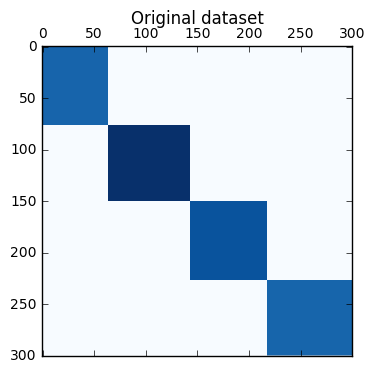

In [6]:
nblocks = 4
nrows = 300
sigma = 0

data, rows, columns = make_biclusters(
    shape=(nrows, nrows), n_clusters=nblocks, noise=sigma,
    shuffle=False, random_state=0)

print(data)

print('\nRow block sizes:')
for r in rows: print(sum(r))
print('\nColumn block sizes:')
for c in columns: print(sum(c))
    
plt.matshow(data, cmap=plt.cm.Blues)

plt.title("Original dataset")
plt.xticks(np.arange(0, nrows+1, 50));
plt.yticks(np.arange(0, nrows+1, 50));

## Symmetric reordering of rows and columns

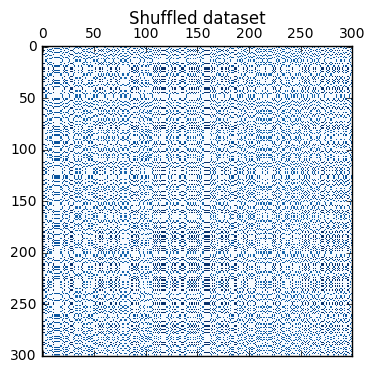

In [8]:
data, row_idx, col_idx = sg._shuffle(data, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)

plt.title('Shuffled dataset')
plt.xticks(np.arange(0, nrows+1, 50));
plt.yticks(np.arange(0, nrows+1, 50));

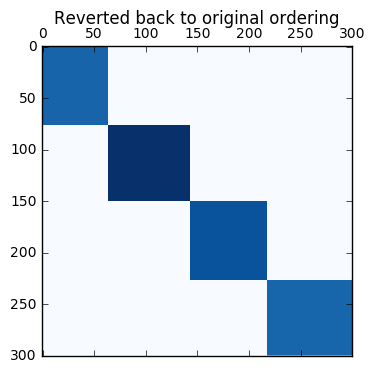

In [4]:
# Reverting back for a check

backdata = data[np.argsort(row_idx),:]
backdata = backdata[:, np.argsort(col_idx)]

plt.matshow(backdata, cmap = plt.cm.Blues)

plt.title('Reverted back to original ordering')
plt.xticks(np.arange(0, nrows+1, 50));
plt.yticks(np.arange(0, nrows+1, 50));

## Reordering rows and columns using spectral co-clustering

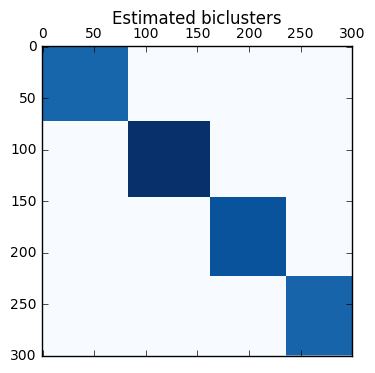

Consensus score: 1.000


In [12]:
model = SpectralCoclustering(n_clusters=nblocks, random_state=0, n_svd_vecs=1)
model.fit(data)

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)

plt.title("Estimated biclusters")
plt.xticks(np.arange(0, nrows+1, 50));
plt.yticks(np.arange(0, nrows+1, 50));

plt.show()

score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("Consensus score: {:.3f}".format(score))

## Examining singular vectors

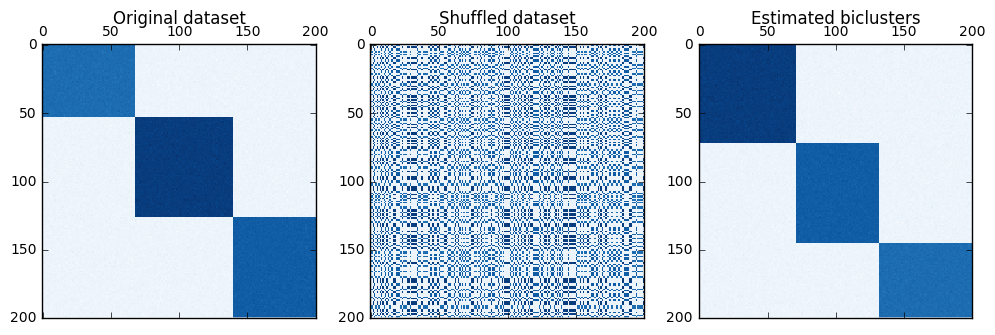

Top singular values:
[ 1.00062825  1.          0.99978259  0.00668358  0.00654827  0.0063529 ]


In [6]:
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans

figs, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

# generating input data
n_clusters = 3
nrows = 200
sigma = 1

W, rows, columns = make_biclusters(
    shape=(nrows, nrows), n_clusters=n_clusters, noise=sigma,
    shuffle=False, random_state=0)

ax[0].matshow(W, cmap=plt.cm.Blues)

ax[0].set_title('Original dataset')
ax[0].set_xticks(np.arange(0, nrows+1, 50));
ax[0].set_yticks(np.arange(0, nrows+1, 50));


# random reordering of matrix rows and columns
W, row_idx, col_idx = sg._shuffle(W, random_state=0)

ax[1].matshow(W, cmap=plt.cm.Blues)

ax[1].set_title('Shuffled dataset')
ax[1].set_xticks(np.arange(0, nrows+1, 50));
ax[1].set_yticks(np.arange(0, nrows+1, 50));

# normalized matrix
row_diag = np.asarray(1.0 / np.sqrt(W.sum(axis=1))).squeeze()
col_diag = np.asarray(1.0 / np.sqrt(W.sum(axis=0))).squeeze()
tW = row_diag[:, np.newaxis] * W * col_diag

n_components = 6 # number of singular vectors to return
n_discard = 0 # number of first singular vectors to discard

# singular value decomposition
u, s, vt = svds(tW, k=n_components)

# sorting eigenvalues and eigenvectors
argS = np.argsort(-s)
s=s[argS]
u=u[:,argS]
vt = vt[argS,:]

u = u[:, n_discard:]
vt = vt[n_discard:]
v = vt.T

# stack singular vectors
z = np.vstack((row_diag[:, np.newaxis] * u, col_diag[:, np.newaxis] * v))

# cluster using k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(z)
labels = kmeans.labels_

n_rows = W.shape[0]
row_labels_ = labels[:n_rows]
column_labels_ = labels[n_rows:]

rows_ = np.vstack(row_labels_ == c for c in range(n_clusters))
columns_ = np.vstack(column_labels_ == c for c in range(n_clusters))

# reorder the matrix
fit_data = W[np.argsort(row_labels_)]
fit_data = fit_data[:, np.argsort(column_labels_)]

ax[2].matshow(fit_data, cmap=plt.cm.Blues)

ax[2].set_title("Estimated biclusters")
ax[2].set_xticks(np.arange(0, nrows+1, 50));
ax[2].set_yticks(np.arange(0, nrows+1, 50));

plt.show()

print('Top singular values:')
print(s)


## Checking singular vectors

We now examine singular vectors and observe that some of them clearly indicate the matrix block structure.

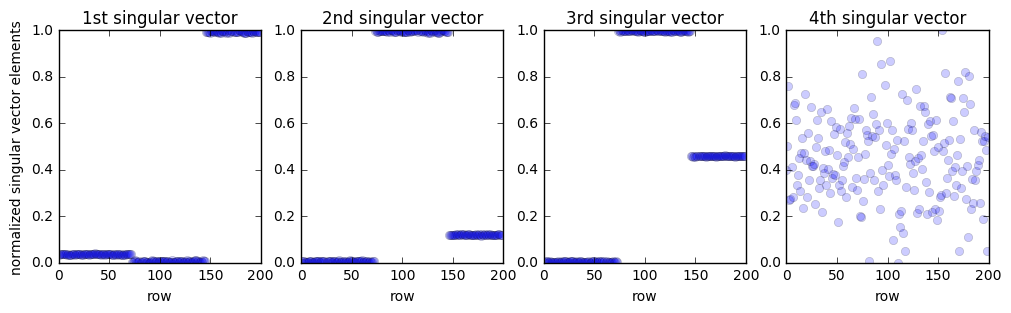

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
#plt.subplots_adjust(wspace=0.6)

zz = z[0:nrows,0]
zz = zz[np.argsort(row_labels_)]
ax[0].plot((zz-max(zz))/(-min(zz-max(zz))) + 1, 'o', alpha=0.2)

ax[0].set_title('1st singular vector')
ax[0].set_xlabel('row')
ax[0].set_ylabel('normalized singular vector elements')

zz = z[0:nrows,1]
zz = zz[np.argsort(row_labels_)]
ax[1].plot((zz-max(zz))/(-min(zz-max(zz))) + 1, 'o', alpha=0.2)

ax[1].set_title('2nd singular vector')
ax[1].set_xlabel('row')

zz = z[0:nrows,2]
zz = zz[np.argsort(row_labels_)]
ax[2].plot((zz-max(zz))/(-min(zz-max(zz))) + 1, 'o', alpha=0.2)

ax[2].set_title('3rd singular vector')
ax[2].set_xlabel('row')

zz = z[0:nrows,3]
zz = zz[np.argsort(row_labels_)]
ax[3].plot((zz-max(zz))/(-min(zz-max(zz))) + 1, 'o', alpha=0.2)

ax[3].set_title('4th singular vector')
ax[3].set_xlabel('row')

plt.show()